<a href="https://colab.research.google.com/github/Jabezng2/Credit-Card-Fraud-Detection/blob/main/Assignment1/Sc3000_Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>SC3000 Lab Assignment 1: "Balancing a pole on a cart"<h1>




## Team Contribution (A33)

|<h4>Name</h4>|<h4>Matriculation Number</h4>|<h4>Contribution</h4>|
|:-|:-:|:-|
|<h4>Lim Jun Hern</h4> |<h4>U2120981B</h4>| <ul><li>Debugging and testing</li><p></p><li>Optimize and improve the code structure</li><p></p><li>Create and refine explanations for each block</li><ul>     
|<h4>Jabez Ng Yong Xin</h4> |<h4>U2120757D</h4>| <ul><li>Create and Digitalize Simulation Function</li><p></p><li>Optimize Performance by finetuning parameters</li><p></p><li>Create and refine explanations for each block</li></ul>
|<h4>Leong Hong Yi</h4>|<h4>U2120932C</h4>| <ul><li>Implement Q-Learning Algorithm</li><p></p><li>Optimize Performance by finetuning parameters</li><p></p><li>Create and refine explanations for each block</li><ul>



<div><h2>Installing Dependencies:</h2></div>

In [16]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importing dependencies and define helper functions

In [17]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

##Loading CartPole environment

In [18]:
env = gym.make("CartPole-v1")

<div class="alert alert-block alert-info"><h2>Task 1: Development of an Rl agent</h2></div>


***Epilson Greedy Q-Learning Algorithm*** will be utilised which essentially selects the action with the highest estimated reward most of the time. It aims to achieve a balance between ***exploration (randomness -> epsilon)*** and ***exploitation (maximisation -> greedy)***. 


###**1. Q-Table Initialisation**
Arbitratily initialise the Q-Table.
<br><br>
After numerous attempts, we define the ***lower limit*** and ***upper limit*** for both **Cart Velocity** and **Pole Angular Velocity** to be **-4** and **4** respectively, because if the velocity is too high, the pole is likely to fall.

In [19]:
def Qtable(stateSpace, actionSpace, binSize):
    
  #bin = number of possible states per catagory
  #np.linspace(start, end, num), create array with Num elements with equal interval between start to end
       
  bin = [np.linspace(-4.8, 4.8, binSize), # Cart Position Observation Space
            np.linspace(-4, 4, binSize), # Cart Velocity Observation Space
            np.linspace(-0.418, 0.418, binSize), # Pole Angle Observation Space
            np.linspace(-4, 4, binSize)] # Pole Angular Velocity Observation Space

  # Initialise Qtable
  # np.random.uniform is used to obtain random values from a uniform distribution between -1 and 1  
  qTable = np.random.uniform(-1, 1, ([binSize] * stateSpace + [actionSpace])) # 5d array
  return qTable, bin

###**2. Discretisation Function**
We require our states to be in ***discrete*** format so that we can plug them into our Q-learning algorithm, i.e. access the table in the form of index, starting from 0. Thus, a discretisation function is implemented for this purpose.

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
def Discrete(state, bins):
    digitizedArray = []
    for i in range(len(state)): digitizedArray.append(np.digitize(state[i], bins[i]) - 1) # digitize into diff "segments", -1 to let it start from 0
    return tuple(digitizedArray)

###**3. Epsilon-Greedy Q-Learning Algorithm**
$$\underbrace{Q_{new}(S_{t},A_{t})}_{\scriptstyle\text{New Estimation}}=Q_{old}(S_{t},A_{t})+\mkern-34mu\underset{\text{Learning rate}}{\underset{\Bigl|}{\alpha}}\mkern-30mu[\underbrace{R_{t+1}}_{\scriptstyle\text{Reward}}+\mkern-30mu\underset{\text{Discount rate}}{\underset{\Biggl|}{\gamma}}\mkern-75mu\overbrace{\max Q_{old}(S_{t+1},a)}^{\scriptstyle\substack{\text{Maximum predicted reward, given new state}}}\mkern-45mu-Q_{old}(S_{t},A_{t})]$$

Reference: Lecture notes from Module 5

### ***3.1. Q-Table***
We create and fill a table (Q-table / Q) storing state-action pairs. Using the above formula, possible values of state-action pairs are calculated iteratively. This formula is called the action-value function / Q-function. The function approximates the value of selecting a certain action in a certain state. In this case, Q is the action value function learned by the algorithm. Q approximates the optimal action-value function Q*. In the implementation above for Q-table initialisation, we create a Q-table containing arbitrary values. 

### ***3.2. For each step in each episode, calculate Q-value and update Q-table***
In the QLearning function defined below, we then proceed by following all the steps of episodes. In each step, we select an action A from Q-table Q. Episilon-Greedy selection is applied here which will be elaborated in the following section. As we take action A, our state changes from S to S' and we obtain a reward R. We then utilise these values to update our Q-table entry. This process is repeated till we have iterated through all the episodes defined (30,000)

### ***3.3. Epsilon-Greedy Action Selection***
The epsilon-greedy approach selects the action with the highest estimated reward most of the time. The aim is to strike a balance between exploration and exploitation. Exploration allows us to have some room to try new things (sometimes contradicting what we have already learned) The epsilon value controls the degree of exploration i.e larger epsilon value, higher degree of exploration while smaller epsilon value, lower degree of exploration. In the implementation, the optimal action (action with highest Q-value) is usually selected, else the algorithm explores a random action.

### ***3.4. Why Epsilon-Greedy?***
The epsilon-greedy algorithm is easy to understand and implement, yet it is hard to beat and works as well as more sophisticated algorithms. 

Reference: https://www.baeldung.com/cs/epsilon-greedy-q-learning

### ***3.5. Epsilon-Decay***
This method involves decaying the value of epsilon across the life of an agent to have it learn and act optimally eventually. We can do this by setting the initial epsilon value to 1, and multiplying the epsilon value by a real value (0 < decay_value < 1). This results in a gradual decay in epsilon with more and more episodes. However, after multiple rounds of testing, although epsilon-decay gives us a more stable reward accross multiple attempts, it has not shown to be useful in improving the reward score and we have decided to exclude it from the algorithm.

Reference: https://aakash94.github.io/Reward-Based-Epsilon-Decay/

### ***3.6. Penalty Function*** ###
As our goal for the cart in an episode is to reach the cumulative score as close to 500 as possible, we introduce a ***Penalty function*** instead of pure Reward method in our Q learning algorithm such that whenever the agent makes a mistake, it will receive a penalty. In this context, we penalize ***(negative reward)*** the machine at the state which a bad move was taken, leading to the ***termination state with score lower than 450***. This way, we can better guide our goal-based agent's learning process closer to achieving higher total cumulative score during implementation.

### ***3.7. How did we select the values for parameters?*** ###
We've experimented with different values for ***the number of episodes***, range for ***cart velocity*** and ***pole angular velocity***, ***epsilon value*** as well as ***bin value***.

Among all ***the number of episodes*** that we've tried, ranging from *10000* to *100000*, we've decided to choose **30000**, where the outcome is sufficiently good and the time taken to train the algorithm is not too long.

Instead of using the value given in the lecture, we noticed that by slightly reducing the ***epsilon value*** to **0.15**, we will able to achieve a higher total reward across all episodes.

Other than that, we've tried different ***bin values***, ranging from *15* to *80*. However, **30** seems to give us the optimal value most of the time. When the ***bin value*** is low, the model's accuracy is reduced due to the continuous nature of state values; when the ***bin value*** is high, we have to increase the number of episodes to maintain a good result since there are more entries in the Q table, which is not feasible due to the extended time required to complete the process.

Furthermore, for the values in our Penalty Function, we tried several ***penalty values*** and found out that ***-1e6*** gives the best result as it does not over or under penalize our machine whenever a mistake action was taken. As for the ***treshold score***, after discussions and attempts, ***450*** is found most reasonable so our agent is neither too bias in achieving perfect scores every time nor achieving low scores due to randomness of ***epsilon value***

In [22]:
def QLearning(Qtable, bins):
  totalEpisodes = 30000

  # Discount Factor (gamma) reflects the importance of immediate vs future rewards
  gamma = 0.95

  # Learning Rate (lr) is the size of the step we take in adjusting our actions
  lr = 0.1

  # Epsilon here is associated with how random the decision is
  epsilon = 0.15

  # The epsilon value is decaying, eventually the policy will be stabilized
  # epsilon_decay_value = 0.9996
    
  for episode in range(0, totalEpisodes): # run for XXXXXX times
    currentState = Discrete(env.reset(), bins)

    score = 0 #Score stores the total rewards in each episode 
    done = False
    while not done:
      if np.random.uniform(0, 1) < epsilon: # (< epsilon) Exploration: some random action
        action = env.action_space.sample()
      else: # (> epsilon) Exploitation: finding the largest reward
        action = np.argmax(Qtable[currentState]) # Choose the action(indicated by index) of Qtable[currentState], Qtable[currentState] is a 1D array with 2 elements (which are the Q Value of taking action 0 or 1 at that state respectively)

      observation, reward, done, info = env.step(action) # done = true, means the entire episode is complete; else episode is incomplete
      nextState = Discrete(observation, bins) # Discritize the nextState
      
      score += reward #Add the reward to the cumulative reward score
		
      if (done and score < 450) or not done: #If the entire episode is not finished or the episode ends too early
        maxFutureQ = np.max(Qtable[nextState]) #Obtain the maximum Q-value for next state among different actions
        currentQ = Qtable[currentState + (action,)] #Obtain the current Q-value
        
        if (done and score < 450): #Penalise if ends earlier without achieving satisfactory reward
          reward = -1e6

        newQ = currentQ + lr * (reward + gamma * maxFutureQ - currentQ) #Calculate the new Q-value
        Qtable[currentState + (action,)] = newQ #Update the Q-value, by accessing table using tuple of 5 items
        currentState = nextState #Update the state

    #Printing function to better understand the training process
    if (episode % 1000 == 0 and episode >= 5000):
      print("Reward of", episode, "is :", score)

    # Epsilon value starts to decay after 5000 episode, and we let the minimum value of epsilon be 0.10
    # if epsilon > 0.10: 
      # if episode > 5000:
        # epsilon = math.pow(epsilon_decay_value, episode - 5000)
  

###**4. Functions to save Q-table**
Despite performing 20 attempts using the parameters above, which took us around 4 hours, we managed to obtain good results most of the time (***average rewards > 470***) using our agent. 
<br><br>However, there were 2 attempts where the result was relatively low (***average rewards ~ 400***), possibly due to the element of randomness in our agent. 
<br><br>
To ensure consistency and prevent the lengthy training phase, instead of training the agent using more episodes everytime we run the algorithm, we decided to store the optimal Q-table we tried, using the function below.


In [23]:
def SaveQTable(tqt): #Function to store the Q-table in 'QTable_1'
  np.save('QTable_1', tqt)
  
def SaveBin(tb):  #Function to store the bin table in 'Bin_1'
  np.save('Bin_1', tb)

### **5. Training Phase**
We created a Q-table for the algorithm to store the Q-values, and run the algorithm. 
<br><br>
If the Q-table already exist, we will simply fetch the Q-table without retraining the agent again; else, we train the Q-table

In [24]:
import os.path

# Check if data exists (Return True or False)
bin_exists = os.path.exists('Bin_1.npy')
qtable_exists = os.path.exists('QTable_1.npy')

if bin_exists and qtable_exists:
  # If data exists then run Q-Learning algorithm using the data saved
  tb = np.load('Bin_1.npy') # Retrieve the Bin table from Bin_1.npy
  tqt = np.load('QTable_1.npy') # Retrieve the QTable from QTable.npy

else:
  # If data doesn't exists then generate Q-table and save the respective data
  tqt, tb = Qtable(4, 2, 30) #Randomly generate QTable and binTable
  QLearning(tqt, tb) # Train the agent
  SaveQTable(tqt) # Save QTable after training
  SaveBin(tb) # Save Bin table after training

###**6. Demonstrate correctness**
We demonstrate the correctness of the agent by sampling a random state from the cart pole environment, inputting to the agent, and outputting a chosen action. The values of state and chosen action is printed in the form of a 1D array with the index ([0],[1]) as the actions and the corresponding values as the Q-values of the action-state. 

In [25]:
observation = env.reset() #Reset the environment and obtain the state
currentState = Discrete(observation, tb) #Discretize the state
action = np.argmax(tqt[currentState]) #Obtain the optimal action
print("Observation:", observation)
print("Chosen action:", action)
tqt[currentState] #Get the Q values (based on observation space) of the current state, resulting Q values are the Q value if action 0 or 1 is taken in the current state.

Observation: [ 0.03736767 -0.02797996 -0.0497688  -0.00333411]
Chosen action: 0


array([19.95307725, 19.89646663])

**Analyze output** <br>
As **19.97731342 > 19.97427837**, so we chose action 0 (by index). The decision of our agent is correct.

<div class="alert alert-block alert-info"><h2>Task 2: Demonstrate the effectiveness of the RL agent
For this task, we created two functions.</h2></div> 
<br><br>
The first function *run_episode()* is to run one epsiode and return the cumulative reward obtained in that episode. 
<br><br>
The second function *generate_results(size)* is to store the total cumulative reward from different episode ( a total of *size* episodes) into an array. That array will be returned by the function(which will be used for graph plotting) .

In [26]:
def run_episode(): #Run one episode
  done = False
  env = gym.make("CartPole-v1")
  currentState = Discrete(env.reset(), tb) #Discretize the initial state
  cum_score = 0
  while not done:
    action = np.argmax(tqt[currentState]) #Exploitation: Get action that cause the current state to have maximum Q-Value
    observation, reward, done, info = env.step(action) #Perform the action and obtain the relevant information
    currentState = Discrete(observation, tb) #Discretize the state
    cum_score += reward #Add reward to cumulative reward in every step 

  return cum_score #Return the cumulative reward for this episode

In [27]:
def generate_results(size): #Run "size" times of episode and store the cumulative reward into an array
    scoreArrayOfEachEpisode = []
    for i in range(size): 
      scoreArrayOfEachEpisode.append(run_episode()) #Add the cumulative reward into the array
    return scoreArrayOfEachEpisode #Return the array

## Plot
For this task, we generated 100 eopisodes and save the cumulative rewards in *episode_results*. We then plot *episode_results* on a graph to analyze our agent's average performance

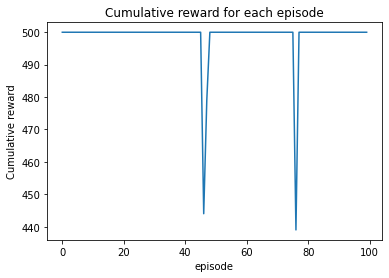

In [28]:
episode_results = generate_results(100) #Generate results for 100 episodes
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

In [29]:
mean = np.mean(episode_results) #Calculate mean cumulative reward
print("Average cumulative reward:", mean)
print("Is my agent good enough?", mean> 195)

Average cumulative reward: 498.62
Is my agent good enough? True


### **Analyze output**
Graph of Cumulative Reward aginst Episodes shows some variation with
some low cumulative rewards while majority attained 500 points(maximum cumulative reward). 
<br><br>
This result could be due to the randomness of the starting state and because some of the Qtable values could suffer from overestimation bias (approximates maximum action value using maximum estimated action value)

<div class="alert alert-block alert-info"><h2>Task 3: Render one episode played by the agent</h2></div>

One episode played by the developed Q-Learning agent is rendered

In [30]:
done = False
env = RecordVideo(gym.make("CartPole-v1", new_step_api=True), "./video")
currentState = Discrete(env.reset(), tb)
cum_score = 0
while not done: 
  env.render()
  action = np.argmax(tqt[currentState]) #Exploitation: Get optimal action that results in maximum Q-Value
  observation, reward, done, info = env.step(action) #Plug in the action to the agent
  currentState = Discrete(observation,tb) #Discretize the state
  cum_score += reward #Add reward to cumulative score in every step 
print("Cumulative Score = ", cum_score) #Print out the cumulative score
env.close()
show_video() #Display the video

/usr/local/lib/python3.9/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Cumulative Score =  500.0


### **Analyze output**
As expected, the output is very good since we obtained close to the maximum score. 

The agent successfully balanced the pole, maintained its position to avoid ending the episode early, and survived for 500 episodes by selecting the correct actions.